# Neural DFT

Q: Is it possible to learn DFT with neural network?

A: Sure, neural networks are general purpose function approxomators!


Q: Alright, how about, using a neural net with a single hidden layer? Such that learned filters will resamble periodict sinusoids with varying frequencies?

In [1]:
import pathlib

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import torch

from IPython.display import Audio, display

In [2]:
def dft_vectorized_kernel(signal):
    K = signal.shape[0]
    N = signal.shape[0]
    spectrum = np.zeros_like(signal, dtype=np.complex)
    # for each frequency
    for i in range(K):
        frquency_kernel = np.exp(-1j * 2 * np.pi * np.arange(0, N) * i / N) 
        spectrum[i] = np.dot(signal, frquency_kernel)

    return spectrum

def dft_vectorized(signal):
    N = signal.shape[0]

    i, j = np.meshgrid(np.arange(N), np.arange(N))
    dft_matrix = np.exp(-1j * 2 * np.pi * i * j / N) 
    return dft_matrix.dot(signal)

In [2]:
def plot_kernel(kernels, kernel_id=0):
    n_filters = kernels.size(0)
    plt.plot(kernels[kernel_id, :], label='cos')
    plt.plot(kernels[n_filters//2 + kernel_id, :], label='sin')
    plt.legend(loc='upper right')
    plt.show()

# Fourier transform
- Can be though as a set of __correlations__ of a signal with basis of periodic functions.
- Corelation with a periodic function in a complex domain is a clever way to achive translation invariance!

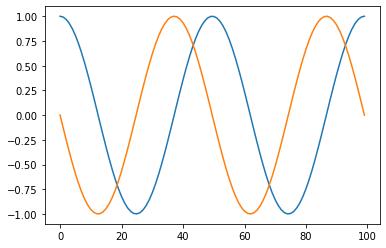

In [4]:
x = np.linspace(-np.pi*2, np.pi*2, num=100)
y = np.exp(-1j * x)
plt.plot(y.real)
plt.plot(y.imag)
plt.show()

<IPython.core.display.Javascript object>


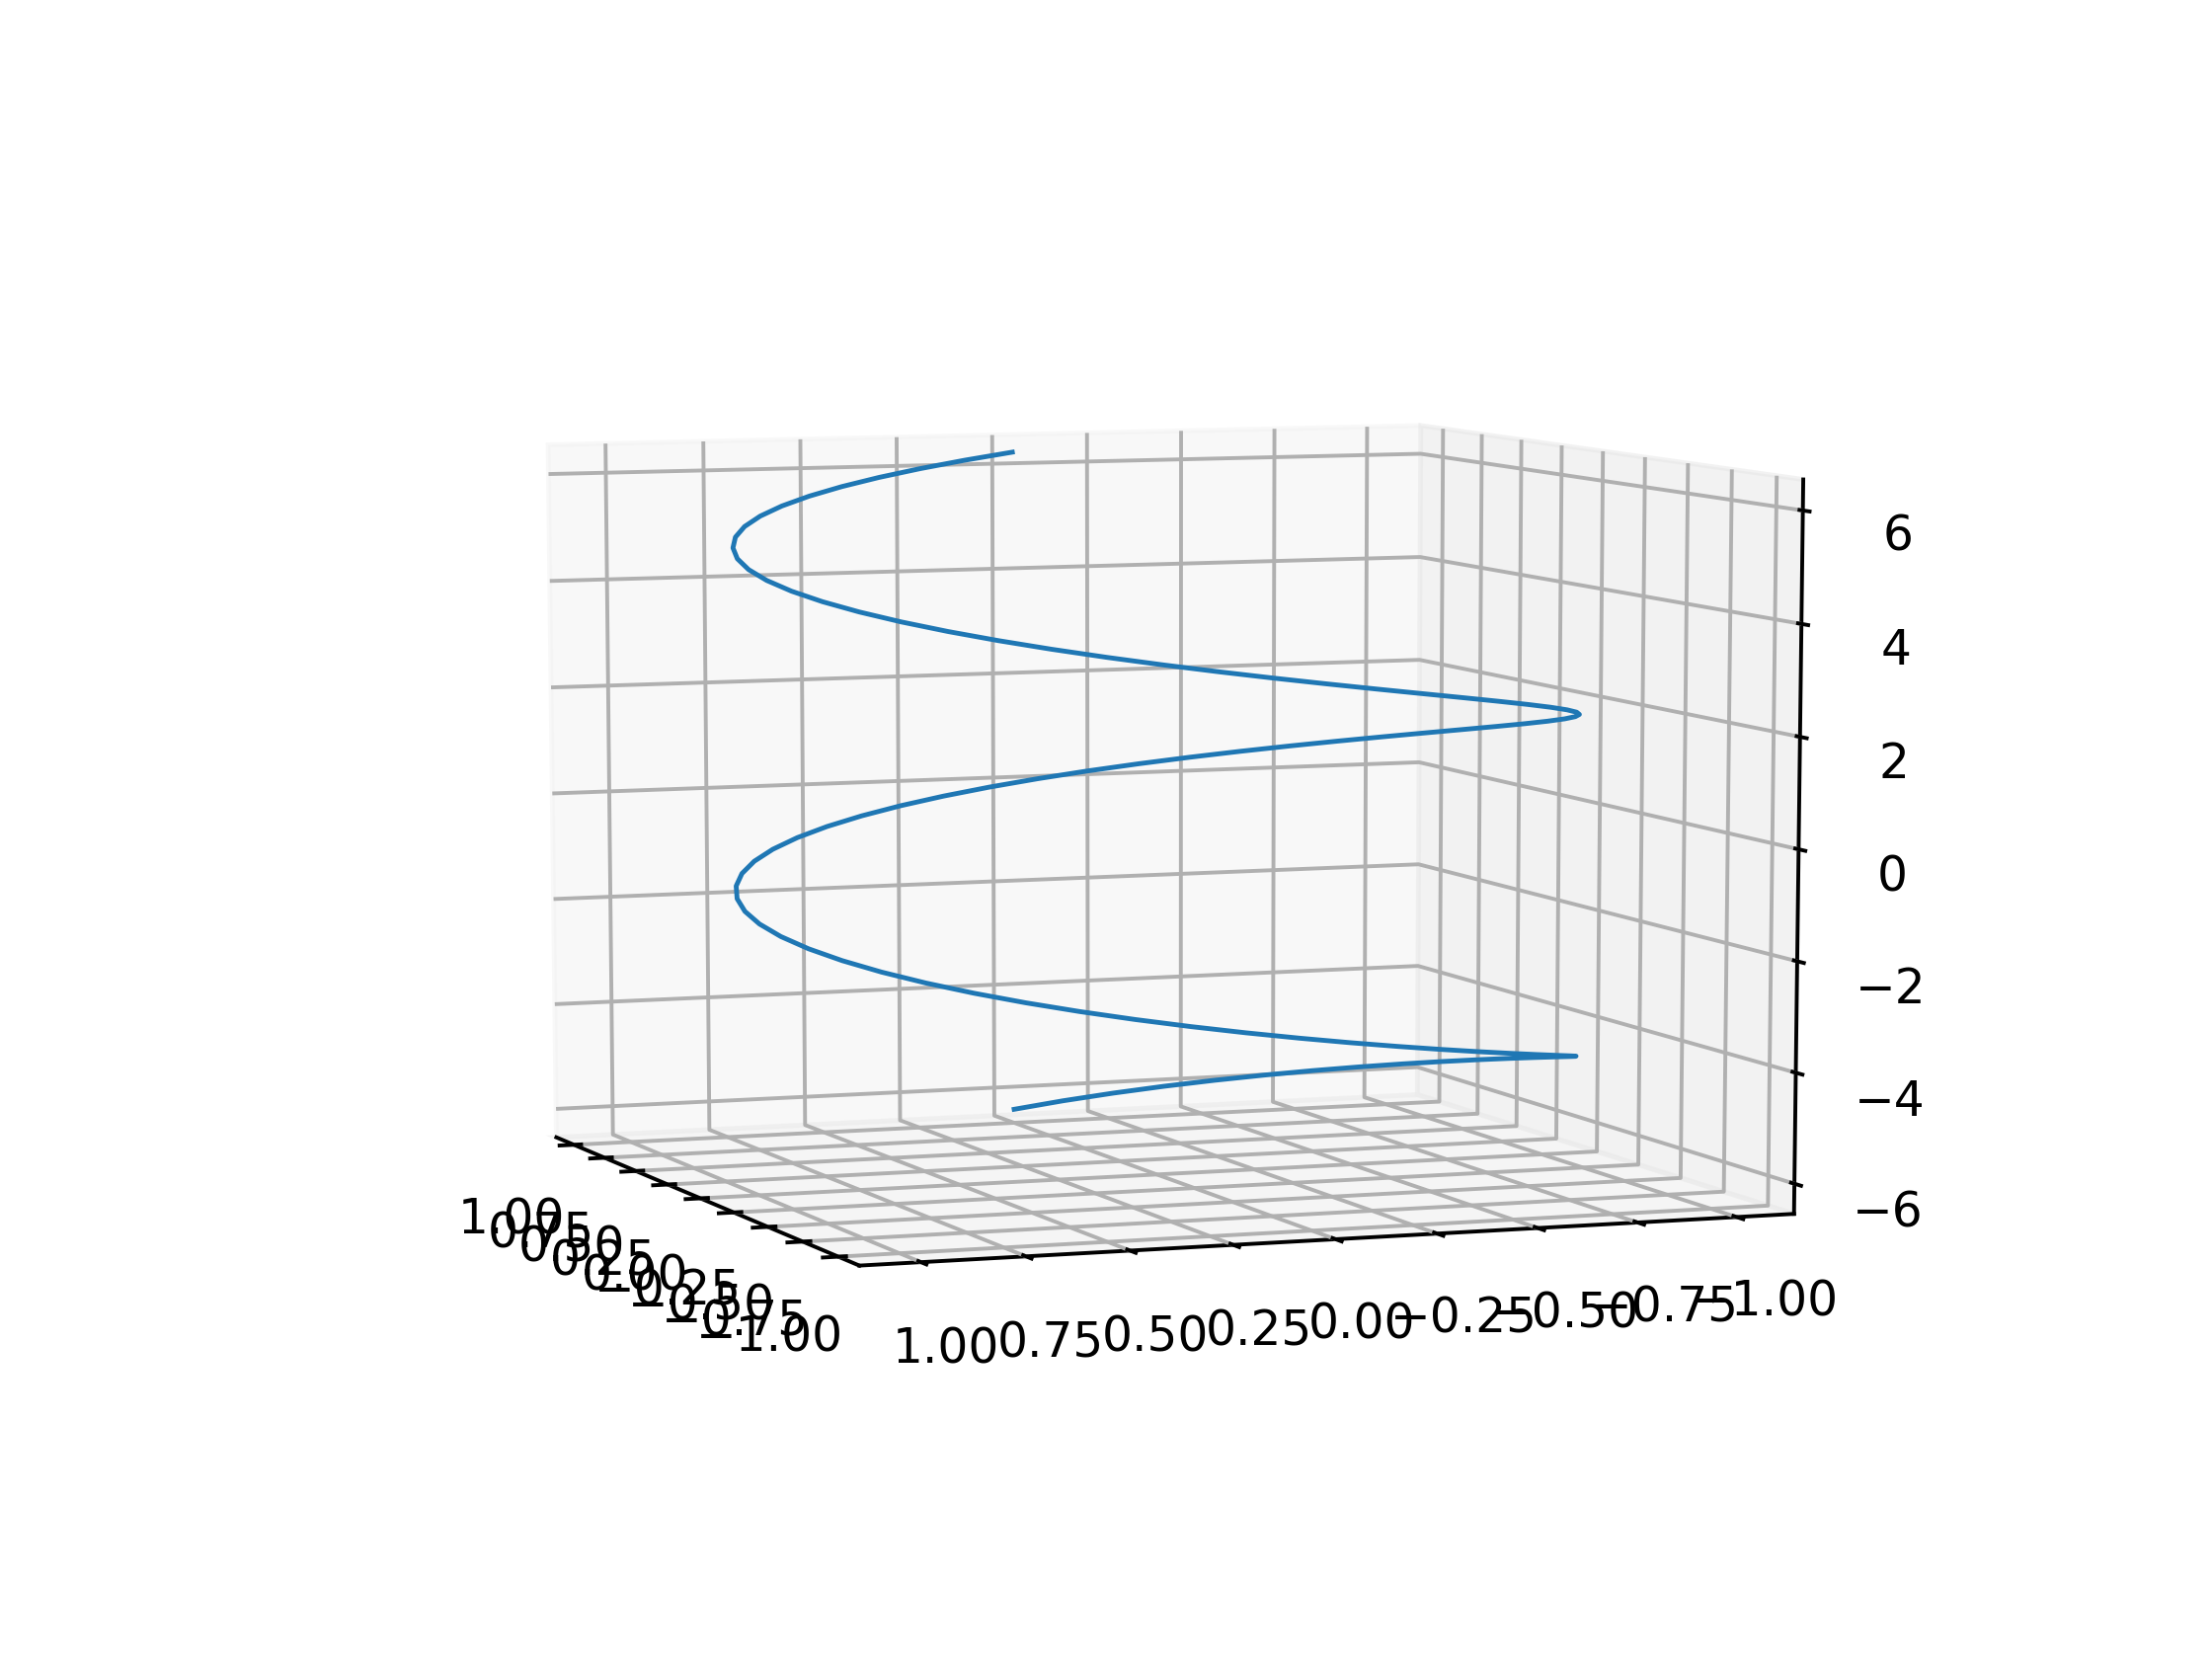

In [19]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(y.real, y.imag, x, lw=1)
plt.show()

# Fourier Basis 

In [3]:
filter_length = 256
fourier_basis = np.fft.fft(np.eye(filter_length))

cutoff = int((filter_length / 2 + 1))
fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                           np.imag(fourier_basis[:cutoff, :])])
fourier_basis = torch.from_numpy(fourier_basis)


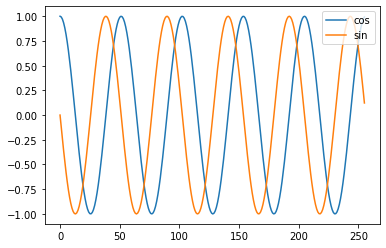

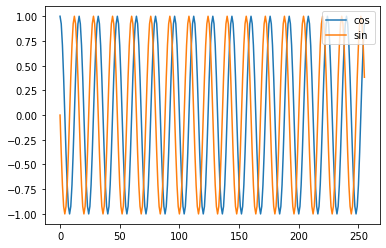

In [4]:
plot_kernel(fourier_basis, kernel_id=5)
plot_kernel(fourier_basis, kernel_id=16)

# Randomly initialized kernels

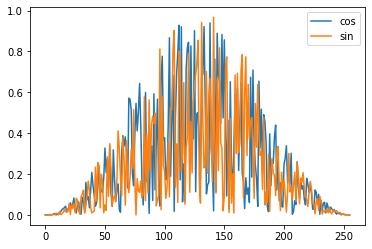

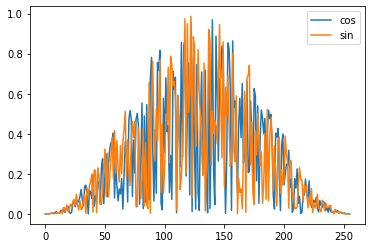

In [5]:
params = torch.load('./experiments/trainable_fft_-1')
kernels = params['forward_basis'].squeeze(1)
plot_kernel(kernels, kernel_id=5)
plot_kernel(kernels, kernel_id=16)

# Learned complex kernels

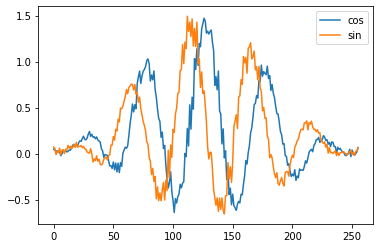

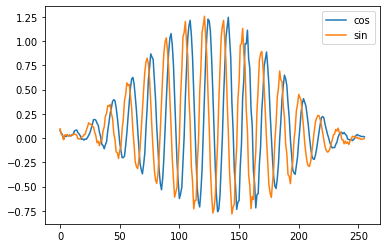

In [6]:
params = torch.load('./experiments/trainable_fft_30')
kernels = params['forward_basis'].squeeze(1)
plot_kernel(kernels, kernel_id=5)
plot_kernel(kernels, kernel_id=16)

# Data Augmentations

Usually we have a limited amount of training data, and data augmentations help us to get more variety in training data while preserving some _invarience_.

As for invariance it can be timber, pitch, linguastic content.

- for ASR it's necessary to preserve a linguasitc content of the utterance.
- for Speech Synthesis, we want voice to stay consistant.

Hence augmentations should be selected accordingly to task we are solving.

Papers:
- RoomSimulator: https://storage.googleapis.com/pub-tools-public-publication-data/pdf/509254e34b4c496eb3cfa1c2be1e1b5fc874bee3.pdf
- SpecAugment for ASR https://arxiv.org/abs/1904.08779
- WavAugment https://arxiv.org/pdf/2007.00991.pdf

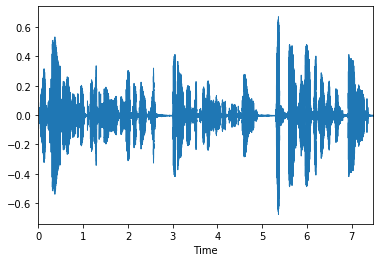

In [5]:
wav_path = pathlib.Path('./data/wav_22050/lj_speech.22050.wav')
wav, sampling_rate = librosa.load(wav_path)
librosa.display.waveplot(wav, sampling_rate)
Audio(wav, rate=sampling_rate)

In [3]:
def augment_additive_noise(signal, noise):
    assert signal.ndim == 1
    assert signal.ndim == noise.ndim
    
    mix = signal + noise[:signal.shape[0]]
    mix /= np.max(np.abs(mix))
    return mix

def augment_room_simulation(signal, impulse_response):
    assert signal.ndim == 1
    assert signal.ndim == impulse_response.ndim

    output = np.convolve(signal, impulse_response)
    return output[:signal.shape[0]]

# Aditive noise

- straightforward to compute.
- very usfull data augmentation, when used can drastically improve quality of learned features.


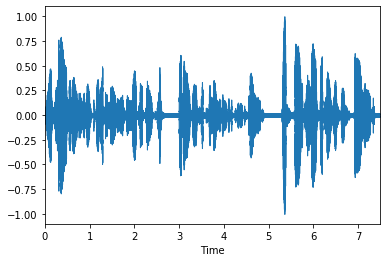

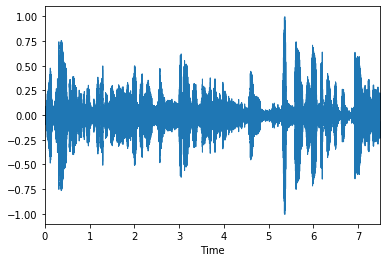

In [6]:
# random noise
noise = (np.random.rand(wav.shape[0]) * 2.0 - 1.0) * 0.01
noised_wav = augment_additive_noise(wav, noise)
librosa.display.waveplot(noised_wav, sampling_rate)
display(Audio(noised_wav, rate=sampling_rate))
plt.show()
# music on background
music, music_sr = librosa.load('./data/wav_22050/piano.22050.wav', offset=5)
assert sampling_rate == music_sr
musicized_wav = augment_additive_noise(wav, music)
librosa.display.waveplot(musicized_wav, sr=sampling_rate)
display(Audio(musicized_wav, rate=sampling_rate))
plt.show()

# Reverberation

[OpenAIR](https://openairlib.net/)

- allows to simulate physical environment
- requires impulse responses, IR
- reverberation effect can be described as a convolution of a signal with IR.

In [7]:
nuclear_reactor_ir, _ = librosa.load('./data/r1-nuclear-reactor-hall/stereo/r1_ortf.wav', duration=7)
ljspeech_in_nuclear_reactor = augment_room_simulation(musicized_wav, nuclear_reactor_ir)
display(Audio(ljspeech_in_nuclear_reactor, rate=sampling_rate))

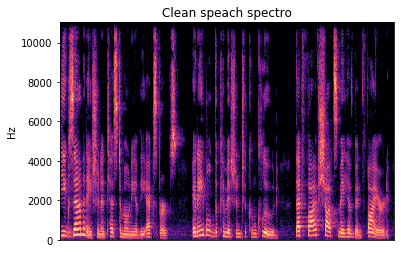

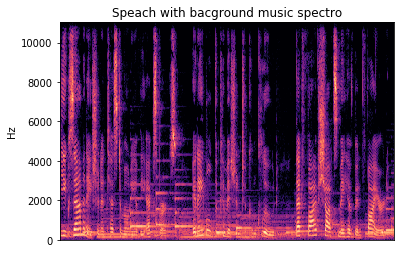

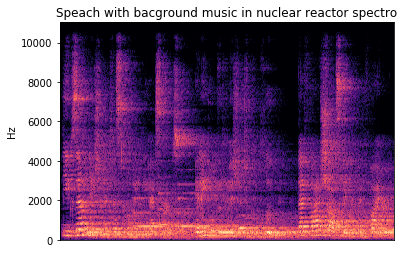

In [13]:
stft = librosa.stft(wav, n_fft=512)
mag, phase = librosa.magphase(stft)
D = librosa.amplitude_to_db(mag, ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.title('Clean speach spectro')
plt.show()

stft = librosa.stft(musicized_wav, n_fft=512)
mag, phase = librosa.magphase(stft)
D = librosa.amplitude_to_db(mag, ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.title('Speach with bacground music spectro')
plt.show()

stft = librosa.stft(ljspeech_in_nuclear_reactor, n_fft=512)
mag, phase = librosa.magphase(stft)
D = librosa.amplitude_to_db(mag, ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.title('Speach with bacground music in nuclear reactor spectro')
plt.show()

# Spectral domain data augmentations

it can be benefitial to apply augmentations is spectral domain, for several reasons:
- we can save time on waveform to spectrogram transformation on training
- spectrograms are outputs of majority of Speech Synethesis algorithms
- effective augmentations for ASR tasks

According to [SpecAugment](https://arxiv.org/pdf/1904.08779.pdf) Can bring down WER significantly even when model was trained on almost 1k hours of data.

<img src="assets/SpecAugment-WER.png" alt="SpecAugment" style="width: 500px;"/>

## Band rejection

- Specify a band of frueqncies and mask them out in a spectrogram.
- Straightforward to implement in spectral domain, might be tedious to apply in time domain.

## Time drop
- Simmilar to Band regection, Specify a range of frames mask them out in a spectrogram.

In [14]:
def mask2d(spectrogram, dim1_mask_idxs=None, dim2_mask_idxs=None):
    log_zero = -80.0
    assert spectrogram.ndim == 2
    if dim1_mask_idxs:
        for idxs in dim1_mask_idxs:
            spectrogram[idxs[0]:idxs[1], :] = log_zero
    if dim2_mask_idxs:
        for idxs in dim2_mask_idxs:
            spectrogram[:, idxs[0]:idxs[1]] = log_zero
    return spectrogram

(257, 1290)


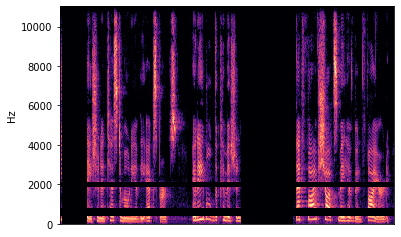

In [15]:
D = mask2d(D, [(10, 20), (45, 50)], [(10, 108), (700, 900)])
print(D.shape)
librosa.display.specshow(D, y_axis='linear')
plt.show()

# Augmentations [conclusion]
There are other data augmentations, like pitch shift, available from SoX, and recently reported being effective for tasks of representation learning [WavAugment](https://arxiv.org/pdf/2007.00991.pdf) 

# Brief history of Speech synthesis
* [parametric speech synthesis (VODER) 1930's, multivoice speech synthesis was possibgle 80 years ago!](https://ptolemy.berkeley.edu/eecs20/speech/voder.html#:~:text=These%20methods%20are%20%22parametric%22%20in,the%20parameters%20of%20the%20model.)
* [overview of TTS systems by SciForce](https://medium.com/sciforce/text-to-speech-synthesis-an-overview-641c18fcd35f)

In [16]:
from IPython.display import YouTubeVideo

def display_yotube_video(url, **kwargs):
    """
    Displays a Youtube video in a Jupyter notebook.
    
    Args:
        url (string): a link to a Youtube video.
        **kwargs: further arguments for IPython.display.YouTubeVideo
    
    Returns:
        YouTubeVideo: a video that is displayed in your notebook.
    """
    id_ = url.split("=")[-1]
    return YouTubeVideo(id_, **kwargs)

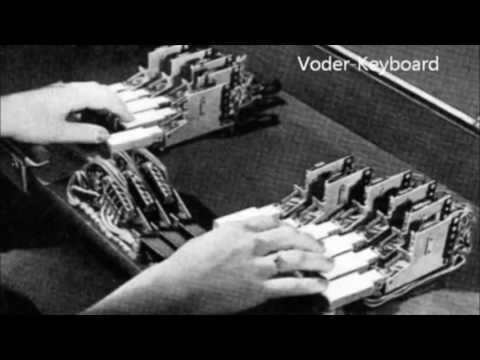

In [17]:
display_yotube_video("https://www.youtube.com/watch?v=TsdOej_nC1M", width=800, height=600)